In [1]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# 파일 불러오기
df = pd.read_pickle("remove_none_in_abs.p")
df.shape

(12218, 6)

In [24]:
keywords = list(df['keywords'])
keywords[0][:5]

['Data Integration', 'Big Data', 'Data Mining', 'Feature Extraction', 'Roads']

In [29]:
# 키워드들을 단어들로 분리
def keywords_to_words( keywords ):
    result = []
    for keyword in keywords:
        # 2. 영문자가 아닌 문자는 공백으로 변환
        letters_only = re.sub('[^a-zA-Z]', ' ', keyword)
        # 3. 소문자 변환
        words = letters_only.lower().split()
        # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
        # stopwords 를 세트로 변환한다.
        stops = set(stopwords.words('english'))
        # 5. Stopwords 불용어 제거
        meaningful_words = [w for w in words if not w in stops]
        # 6. 어간추출
        wordnet_lemmatizer = WordNetLemmatizer()
        result_words = [wordnet_lemmatizer.lemmatize(w) for w in meaningful_words]
        result.append(result_words)
        
    return(result)

In [18]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [27]:
# 멀티 프로세싱 코드
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [31]:
%time clean_keyword2words = apply_by_multiprocessing(\
    df['keywords'], keywords_to_words, workers=64)

CPU times: user 514 ms, sys: 400 ms, total: 914 ms
Wall time: 30.6 s


In [35]:
clean_keyword2words[0][:10]

[['data', 'integration'],
 ['big', 'data'],
 ['data', 'mining'],
 ['feature', 'extraction'],
 ['road'],
 ['semantics'],
 ['trajectory'],
 ['urban', 'computing'],
 ['big', 'data'],
 ['cross', 'domain', 'data', 'mining']]

In [36]:
sum_keywords = clean_keyword2words.sum()

In [39]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 20 # 최소 문자 수
num_workers = 8 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sum_keywords, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2018-11-29 19:36:18,029 : INFO : collecting all words and their counts
2018-11-29 19:36:18,030 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-29 19:36:18,038 : INFO : PROGRESS: at sentence #10000, processed 19798 words, keeping 2299 word types
2018-11-29 19:36:18,045 : INFO : PROGRESS: at sentence #20000, processed 41393 words, keeping 3909 word types
2018-11-29 19:36:18,051 : INFO : PROGRESS: at sentence #30000, processed 62171 words, keeping 4731 word types
2018-11-29 19:36:18,059 : INFO : PROGRESS: at sentence #40000, processed 84471 words, keeping 5284 word types
2018-11-29 19:36:18,068 : INFO : PROGRESS: at sentence #50000, processed 105108 words, keeping 5711 word types
2018-11-29 19:36:18,079 : INFO : PROGRESS: at sentence #60000, processed 128164 words, keeping 6312 word types
2018-11-29 19:36:18,088 : INFO : PROGRESS: at sentence #70000, processed 150456 words, keeping 6828 word types
2018-11-29 19:36:18,098 : INFO : PROGRESS: at sentence #8

In [40]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

2018-11-29 19:36:21,883 : INFO : precomputing L2-norms of word weight vectors


In [45]:
# 가장 유사한 단어를 추출
model.wv.most_similar('animation')

[('crash', 0.9468654990196228),
 ('crime', 0.9421143531799316),
 ('port', 0.9357457160949707),
 ('us', 0.928912878036499),
 ('virus', 0.9284859895706177),
 ('vision', 0.9233094453811646),
 ('handheld', 0.9230530261993408),
 ('go', 0.9172534942626953),
 ('assisted', 0.9138453006744385),
 ('guidance', 0.9071936011314392)]

In [46]:
# 만든 모델 저장하기
model_name = '300features_40minwords_10text_keywords'
model.save(model_name)

2018-11-29 19:40:47,268 : INFO : saving Word2Vec object under 300features_40minwords_10text_keywords, separately None
2018-11-29 19:40:47,269 : INFO : not storing attribute vectors_norm
2018-11-29 19:40:47,270 : INFO : not storing attribute cum_table
2018-11-29 19:40:47,314 : INFO : saved 300features_40minwords_10text_keywords


In [47]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text_keywords'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:,:])
# X_tsne = tsne.fit_transform(X)

2018-11-29 19:40:49,411 : INFO : loading Doc2Vec object from 300features_40minwords_10text_keywords
2018-11-29 19:40:49,440 : INFO : loading wv recursively from 300features_40minwords_10text_keywords.wv.* with mmap=None
2018-11-29 19:40:49,441 : INFO : setting ignored attribute vectors_norm to None
2018-11-29 19:40:49,441 : INFO : loading vocabulary recursively from 300features_40minwords_10text_keywords.vocabulary.* with mmap=None
2018-11-29 19:40:49,442 : INFO : loading trainables recursively from 300features_40minwords_10text_keywords.trainables.* with mmap=None
2018-11-29 19:40:49,442 : INFO : setting ignored attribute cum_table to None
2018-11-29 19:40:49,443 : INFO : loaded 300features_40minwords_10text_keywords
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


1711
[ 0.0341358   0.0761931  -0.00482992 -0.04901999 -0.05237508  0.0994506
 -0.04172606 -0.00317452  0.01216229 -0.03125408]


In [48]:
w2v_df = pd.DataFrame(X_tsne, index=vocab[:], columns=['x', 'y'])
w2v_df.shape

(1711, 2)

In [49]:
w2v_df.head(10)

,x,y
data,15.149630,27.769064
integration,-29.997438,29.778559
big,21.181629,22.624485
mining,22.572680,23.241903
feature,-9.443121,31.949154
extraction,21.547937,11.763443
road,-0.078566,7.321211
semantics,4.954503,19.934387
trajectory,19.976768,-5.035340
urban,-40.409081,-0.002539


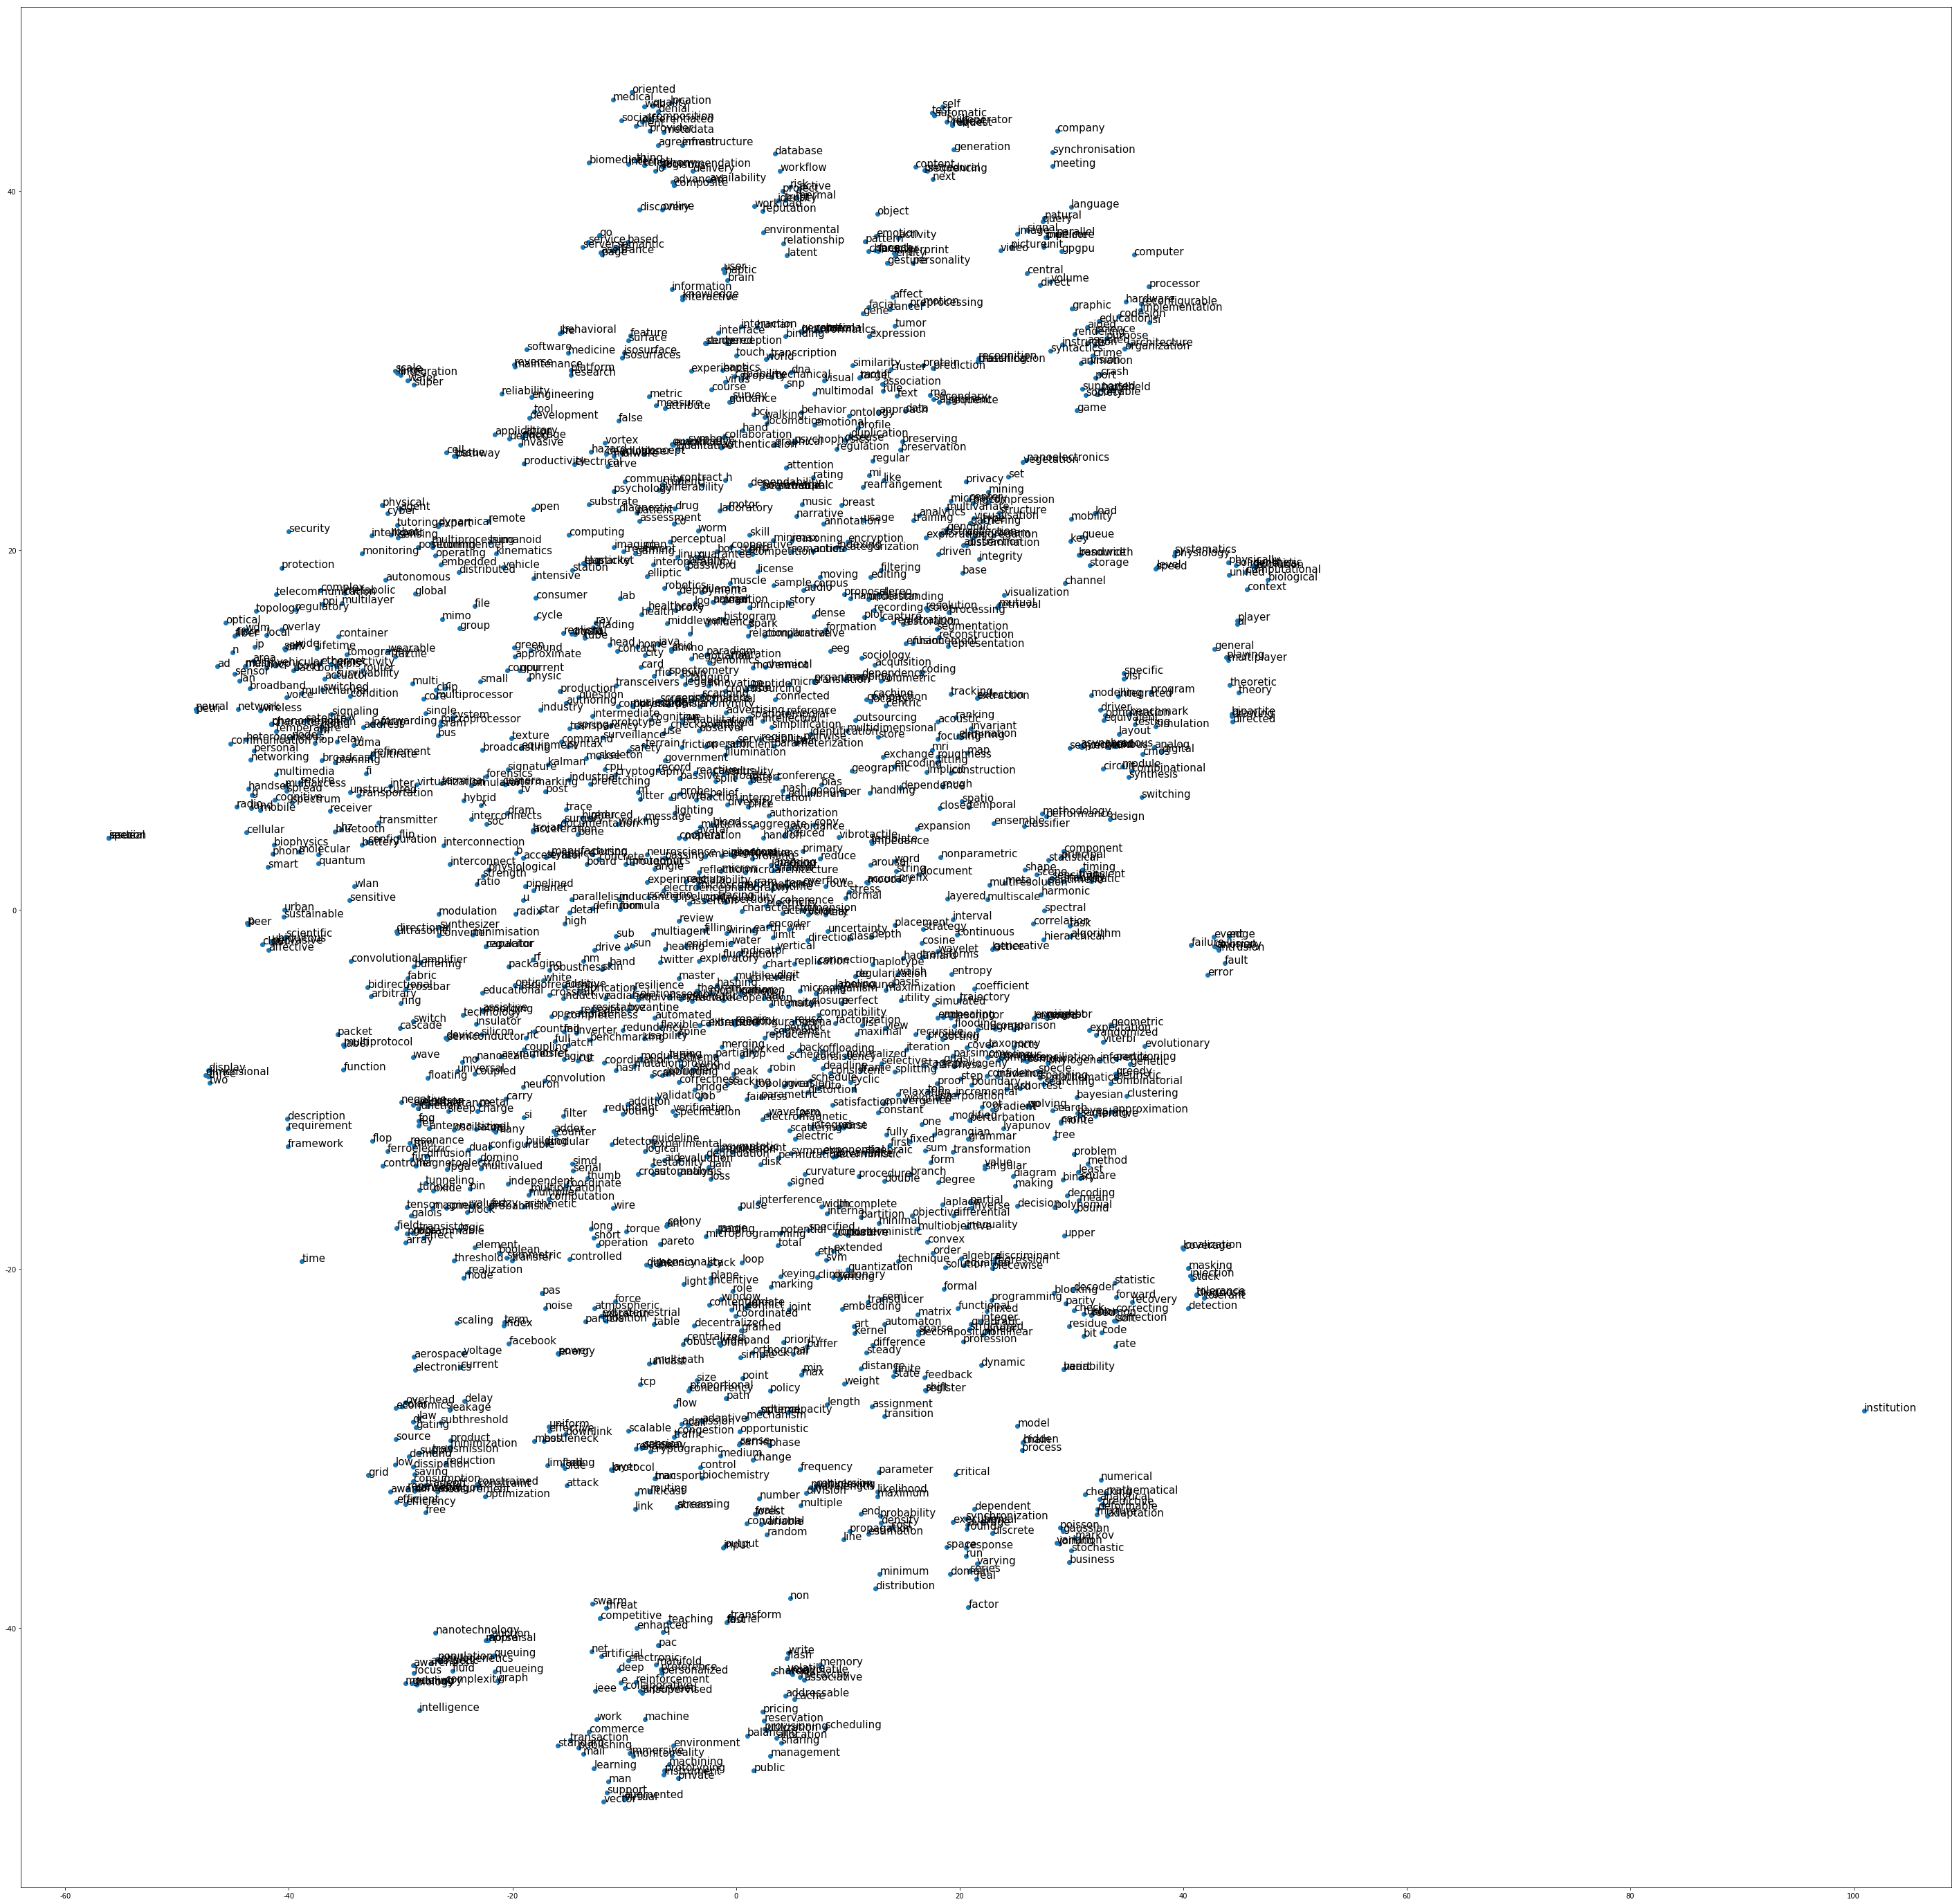

In [51]:
fig = plt.figure()
fig.set_size_inches(50, 50)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_df['x'], w2v_df['y'])

for word, pos in w2v_df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.show()